
# TP 2 : Computer Vision

## Part 3 : motion estimation

In this part of the TP, we are going to look at the following method for estimating motion :

- block matching

First, let us again load some packages and define some helper functions

(448, 624)

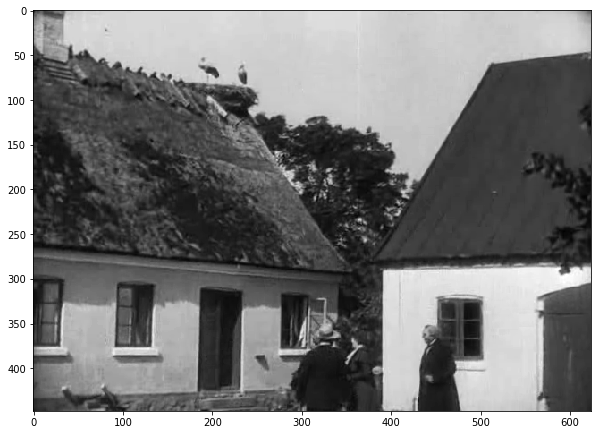

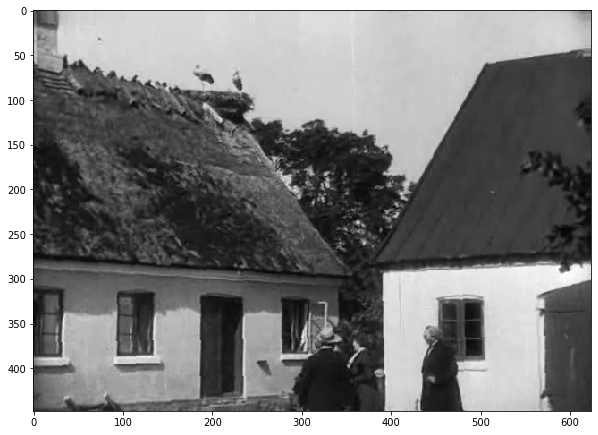

In [2]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np 
import imageio
from skimage import color
from scipy import signal
from scipy.ndimage.morphology import binary_dilation

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

def display_motion(img_1,img_2,key_pts,motion,file_save=''):
    
    motion_x = motion[:,0]
    motion_y = motion[:,1]
    
    img_size = img_1.shape
    
    head_width=2.0
    head_length=3.0

    fig = plt.figure()
    plt.figure(figsize=(10, 10))
    ax = plt.imshow(img_1,cmap='gray')

    print(key_pts.shape[0])
    for i in range(0,key_pts.shape[0]):
        x = key_pts[i,0]
        y = key_pts[i,1]
        plt.arrow(x,y, motion_x[i],motion_y[i] , color='r',
            head_width=head_width, head_length=head_length,)
    plt.gca().set_axis_off()
    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(mpl.ticker.NullLocator())
    plt.gca().yaxis.set_major_locator(mpl.ticker.NullLocator())

    if (file_save != ''):
        plt.savefig(file_save, bbox_inches = 'tight', pad_inches = 0)

file_dir = 'images/'
file_name_1 = 'afgrunden_1'
file_name_2 = 'afgrunden_2'
file_ext = '.png'
img_1,_ = read_image(file_dir+file_name_1+file_ext)
img_2,_ = read_image(file_dir+file_name_2+file_ext)
display_image(img_1)
display_image(img_2)
img_size = img_1.shape
img_size

__Question__ What sort of motion do you think is there between img_1 and img_2 ? You may want to flip between one image and another in an external viewer.

**Motion analysis** is used in computer vision, image processing, high-speed photography and machine vision that studies methods and applications in which two or more consecutive images from an image sequences, e.g., produced by a video camera or high-speed camera, are processed to produce information based on the apparent motion in the images. In some applications, the camera is fixed relative to the scene and objects are moving around in the scene, in some applications the scene is more or less fixed and the camera is moving, and in some cases both the camera and the scene are moving.

Everything naturally wants to move and change. In the world of mechanics, there are four basic types of motion. These four are rotary, oscillating, linear and reciprocating. Each one moves in a slightly different way and each type of achieved using different mechanical means that help us understand linear motion and motion control.

In the **above example** it seems to have a little rotation of the image in the opposite direction of the clock wise.Rotary motion is anything that moves in a circle. This type of motion was among the first discovered in ancient times. Think of a spinning wheel on which people spun wool. A car's engine works the same way. Like linear cylinders, rotary actuators are used across a wide range of industries and come in electric, pneumatic and hydraulic options. 

__Answer__

## Block matching

Block matching is a very intuitive algorithm for motion estimation. We choose a patch size, and for each patch $\Psi_p$ in the first frame, we look for the patch $\Psi_q$ which is the most similar, in a certain region around the original position. The motion $(\delta_x,\delta_y)$ is then defined as $(\delta_x,\delta_y) = q-p$, such that : 

$
\begin{cases}
q_x = p_x+\delta_x\\
q_y = p_y+\delta_y
\end{cases}
$

The ''similarity'' between two patches is the sum of squared differences (SSD) :

$d(\Psi_p,\Psi_q) = \sum_{i \Psi} \left( I(p+i) - I(q+i) \right)^2,$

where $\Psi$ is the patch neighbourhood (a square).

We are going to be implementing block matching in a function called ``block_matching``. However, this can take a lot of time, so we only carry it out on a subset of the pixels, which we will call ``key_pts``. This will be a matrix of size $(N,2)$, where $N$ is the number of keypoints, and where each line has the following format :

- $[x,y]$

Create this function now, with the following parameters :

- block_size = 7 (the patch size)
- search_size = 15 (the maximum distance we search for the same patch in)

You will have to deal with border conditions. There are two ways of doing this :

- not allowing the patch search to go near to the borders (no closer than half the patch size)
- making partial patch comparisons

You can choose either method. The first is slightly easier to implement, but potentially incorrect near the borders. The second is more correct, but you have to make sure to make partial patch comparisons.

Make sure you do __not__ carry out the patch distance calculation with a loop (which would not be very optimal). You can first create the patch neighbourhood $\Psi$ with

- ``np.meshgrid``

and then take the SSD of the two patches.

Fill in the following function.

In [0]:
def square_distance(patch1, patch2):
        
    return np.sum(np.power((patch1 - patch2), 2))

def block_matching(img_1,img_2,key_pts):
    
    alpha = 7
    beta = 15
    
    
    pad_img_1 = np.pad(img_1, alpha, mode='edge')
    pad_img_2 = np.pad(img_2, alpha, mode='edge')
    key_pts = key_pts + alpha
    motion = np.zeros((key_pts.shape))
    
    for k in range(len(key_pts)):
        x, y = key_pts[k,:]
        patch_1 = pad_img_1[y-alpha:y+alpha+1, x-alpha:x+alpha+1]
        area_2 = pad_img_2[y-beta:y+beta+1, x-beta:x+beta+1]
        area_2_pad = np.pad(area_2, alpha, mode= 'edge', )
        distance = np.full((beta*2 +1,beta*2+1), np.inf)
        
        for i in range(alpha,area_2_pad.shape[0]-alpha):
            for j in range(alpha, area_2_pad.shape[1]-alpha):
            
                distance[i-alpha][j-alpha] = square_distance(patch_1, area_2_pad[i-alpha:i+alpha+1, j-alpha:j+alpha+1])
            
        q = np.argwhere(distance == np.min(distance))
        
        motion[k,0] = q[0][1] - beta
        motion[k,1] = q[0][0] - beta
            
    return motion

We now draw some random keypoints to carry out the block matching on.

In [0]:
n_pts = 80
key_pts = np.zeros((n_pts,2)).astype(int)
# a random seed, if you want repeatability
np.random.seed(10)

pixel_list = np.asarray(range(0,img_size[0]*img_size[1]))
np.random.shuffle(pixel_list)
key_pts = np.zeros((n_pts,2)).astype(int)
key_pts[:,1],key_pts[:,0] = np.unravel_index(pixel_list[0:n_pts],img_size)

Carry out the block matching and display the result with the ``display_motion`` function.

In [0]:
motion = block_matching(img_1,img_2,key_pts)

80
80


<Figure size 432x288 with 0 Axes>

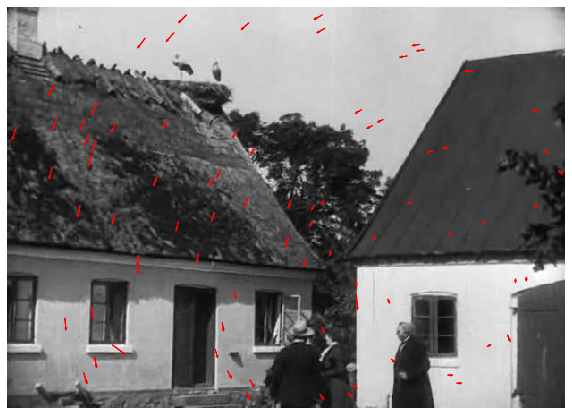

<Figure size 432x288 with 0 Axes>

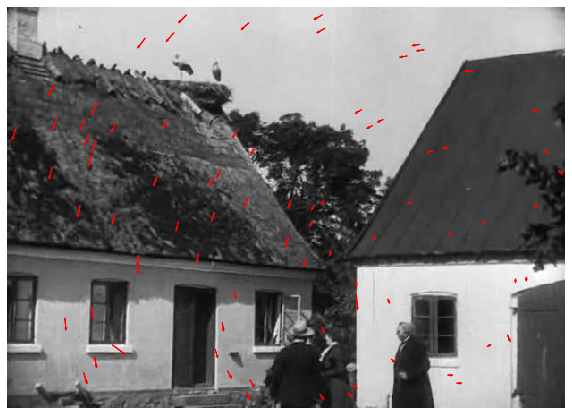

In [6]:
display_motion(img_1,img_2,key_pts,motion)
display_motion(img_1,img_2,key_pts,motion,file_name_1+'_motion_out.png')

__Question__ In what regions do you think the estimation might fail ? Does this visualisation confirm your hypothesis concerning the type of motion ?

__Answer__

A **Block Matching** Algorithm is a way of locating matching macroblocks in a sequence of digital video frames for the purposes of motion estimation. The underlying supposition behind motion estimation is that the patterns corresponding to objects and background in a frame of video sequence move within the frame to form corresponding objects on the subsequent frame. This can be used to discover temporal redundancy in the video sequence, increasing the effectiveness of inter-frame video compression by defining the contents of a macroblock by reference to the contents of a known macroblock which is minimally different. 

**Block matching** along epipolar lines is the core of most stereovision algorithms in geographic information systems. The usual distances betweenblocks are the sum of squared distances in the block (SSD) or the correlation. Minimizing these distances causes the fattening effect, by which the center of the block inherits the disparity of the more contrasted pixels in the block. This fattening error occurs everywhere in the image, and not just on strong depth discontinuities. The fattening effect at strong depth edges is is a particular case of fattening, called foreground fattening effect. A theorem shows that a simple and universal adaptive weighting of the SSD resolves the fattening problem at all smooth disparity points. The optimal SSD weights are nothing but the inverses of the squares of the image gradients in the epipolar direction.With these adaptive weights, it is shown that the optimal disparity func-tion is the result of the convolution of the real disparity with a prefixed kernel. Experiments on simulated and real pairs prove that the method does what the theorem predicts, eliminating surface bumps caused by fat-tening. However, the method does not resolve the foreground fattening.


**The Motion vector** confirm the hypothesis that the type of motion is rotation motion